In [54]:
import math
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import parallel
from torch.backends import cudnn
from torch import optim

from torch.utils import data

from torchvision import datasets
from torchvision import transforms
from torchvision import utils

random.seed(123)
torch.manual_seed(123)

data_directory = "./sample/bedroom"

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
is_gpu = 1 if device == "cude:0" else 0

## Load dataset

In [83]:
def load_dataset(batch_size, image_size, subset_size=10000, is_smoke=False):
    batch_size = 128

    # Spatial size of training images. All images will be resized to this size using a transformer.
    image_size = 64

    
    if is_smoke:
        directory = data_directory + "/0/0"
    else:
        directory = data_directory

    image_folder = datasets.ImageFolder(
        root=directory,
        transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    )

    if not is_smoke and subset_size != -1:
        subset_indices = []

        for class_index in range(len(image_folder.classes)):
            class_indices = np.where(np.array(image_folder.targets) == class_index)[0]
            
            if len(class_indices) >= subset_size:
                selected_indices = np.random.choice(class_indices, size=subset_size, replace=False)
                subset_indices.extend(selected_indices)

        image_folder = data.Subset(image_folder, subset_indices)
    print(image_folder)
    dataloader = data.DataLoader(
        image_folder, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=2
    )

    return dataloader

Dataset ImageFolder
    Number of datapoints: 303125
    Root location: ./sample/bedroom
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


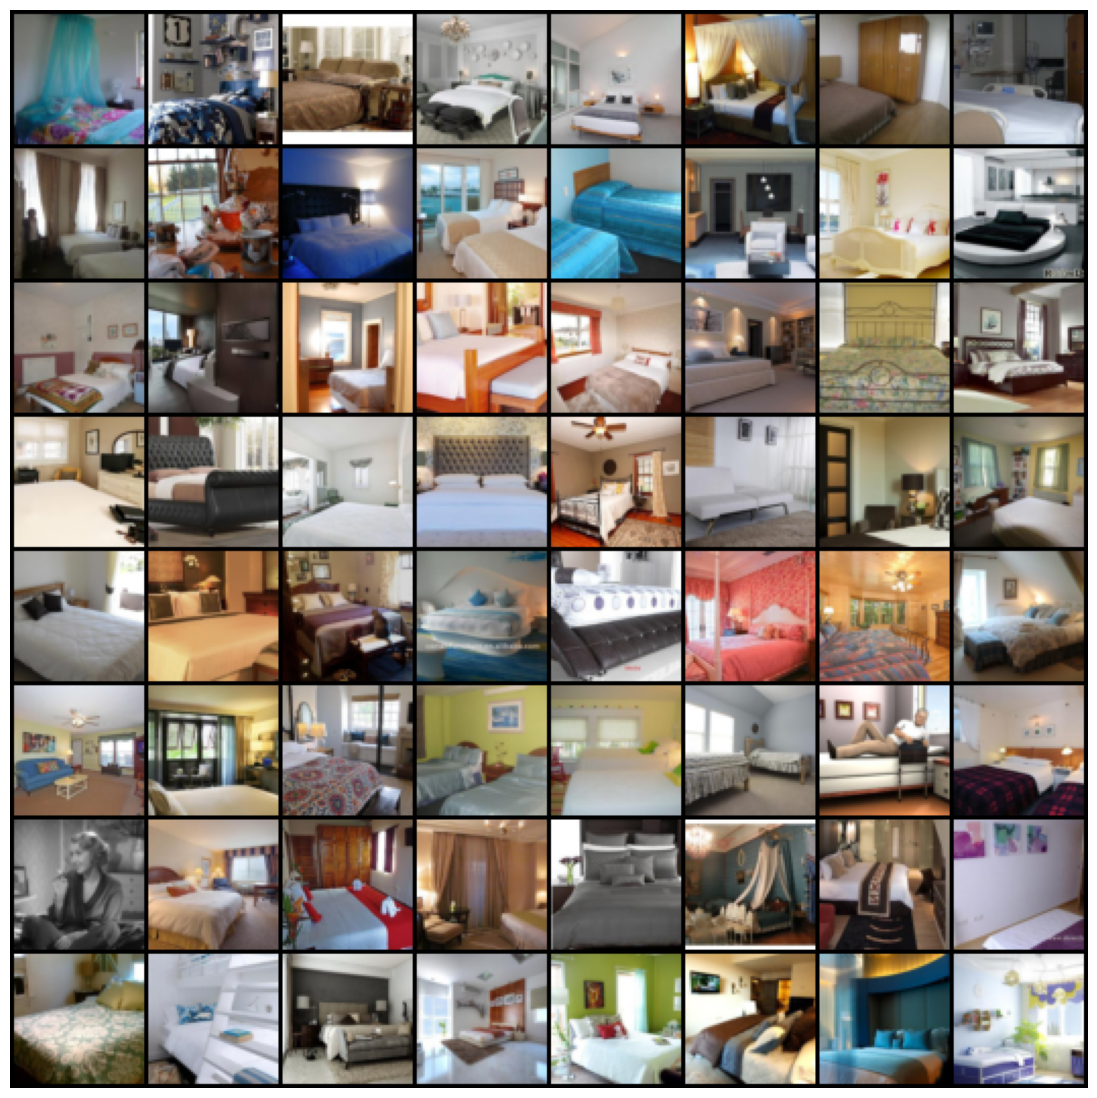

In [85]:
dataloader = load_dataset(batch_size=128, image_size=64, subset_size=-1)

real_batch = next(iter(dataloader))

plt.figure(figsize=(14,14))
plt.axis("off")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## DCGAN

#### Generator and Discriminator

In [86]:
class Generator_DCGAN(nn.Module):
    def __init__(self, size_of_latent_vector, size_of_feature_map_g):
        super(Generator_DCGAN, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(size_of_latent_vector, size_of_feature_map_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(size_of_feature_map_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(size_of_feature_map_g * 8, size_of_feature_map_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size_of_feature_map_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(size_of_feature_map_g * 4, size_of_feature_map_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size_of_feature_map_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( size_of_feature_map_g * 2, size_of_feature_map_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size_of_feature_map_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(size_of_feature_map_g, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


class Discriminator_DCGAN(nn.Module):
    def __init__(self, size_of_feature_map_d):
        super(Discriminator_DCGAN, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, size_of_feature_map_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(size_of_feature_map_d, size_of_feature_map_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size_of_feature_map_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(size_of_feature_map_d * 2, size_of_feature_map_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size_of_feature_map_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(size_of_feature_map_d * 4, size_of_feature_map_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(size_of_feature_map_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(size_of_feature_map_d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


#### Initial weights generator

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## WGAN

#### Generator and Discriminator

In [79]:
class Generator_WGAN(nn.Module):	
	def __init__(self, size_of_latent_vector, size_of_feature_map_g):
		super(Generator_WGAN, self).__init__()
		self.is_gpu = is_gpu
		self.main = nn.Sequential(
			nn.ConvTranspose2d(size_of_latent_vector, size_of_feature_map_g * 8, 4, 1, 0, bias=False),
			nn.BatchNorm2d(size_of_feature_map_g * 8),
			nn.ReLU(True),

			nn.ConvTranspose2d(size_of_feature_map_g * 8, size_of_feature_map_g * 4, 4, 2, 1, bias=False),
			nn.BatchNorm2d(size_of_feature_map_g * 4),
			nn.ReLU(True),

			nn.ConvTranspose2d(size_of_feature_map_g * 4, size_of_feature_map_g * 2, 4, 2, 1, bias=False),
			nn.BatchNorm2d(size_of_feature_map_g * 2),
			nn.ReLU(True),

			nn.ConvTranspose2d(size_of_feature_map_g * 2, size_of_feature_map_g, 4, 2, 1, bias=False),
			nn.BatchNorm2d(size_of_feature_map_g),
			nn.ReLU(True),

			nn.ConvTranspose2d(size_of_feature_map_g, 3, 4, 2, 1, bias=False),
			nn.Tanh(),
		)
		
	def forward(self, input):
		return self.main(input)
   
class Discriminator_WGAN(nn.Module):
	def __init__(self, size_of_feature_map_d):
		super(Discriminator_WGAN, self).__init__()
		self.is_gpu = is_gpu
		self.main = nn.Sequential(
			nn.Conv2d(3, size_of_feature_map_d , 4, 2, 1, bias=False),
			nn.LeakyReLU(0.2, inplace=True),

			nn.Conv2d(size_of_feature_map_d, size_of_feature_map_d * 2, 4, 2, 1, bias=False),
			nn.BatchNorm2d(size_of_feature_map_d * 2),
			nn.LeakyReLU(0.2, inplace=True),

			nn.Conv2d(size_of_feature_map_d * 2, size_of_feature_map_d * 4, 4, 2, 1, bias=False),
			nn.BatchNorm2d(size_of_feature_map_d * 4),
			nn.LeakyReLU(0.2, inplace=True),

			nn.Conv2d(size_of_feature_map_d * 4, size_of_feature_map_d * 8, 4, 2, 1, bias=False),
			nn.BatchNorm2d(size_of_feature_map_d * 8),
			nn.LeakyReLU(0.2, inplace=True),

			nn.Conv2d(size_of_feature_map_d * 8, 1, 4, 1, 0, bias=False),
			nn.Sigmoid(),
		)

	def forward(self, input):
		return self.main(input)


## Training

In [108]:
def training(
    architecture,
    number_of_epochs,
    batch_size, 
    image_size,
    learning_rate,
    beta_adam,
    size_of_feature_map_g, 
    size_of_feature_map_d, 
    size_of_latent_vector,
    is_gpu=0,
    is_smoke=False,
    subset_size=1000,
):
    
    dataloader = load_dataset(batch_size=batch_size, image_size=image_size, subset_size=subset_size, is_smoke=is_smoke)

    real_label = 1.
    fake_label = 0.
    G_losses = []
    D_losses = []
    iters = 0

    if architecture == "DCGAN":
        G = Generator_DCGAN(size_of_latent_vector, size_of_feature_map_g)
        D = Discriminator_DCGAN(size_of_feature_map_d)

        G.apply(weights_init)
        D.apply(weights_init)

        criterion = nn.BCELoss()

        optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta_adam, 0.999))
        optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta_adam, 0.999))

        for epoch in range(number_of_epochs):
            for i, data in enumerate(dataloader, 0):

                # Discriminator
                D.zero_grad()

                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

                output = D(real_cpu).view(-1)
                
                errD_real = criterion(output, label)
                errD_real.backward()
                
                noise = torch.randn(b_size, size_of_latent_vector, 1, 1)

                fake = G(noise)
                label.fill_(fake_label)

                output = D(fake.detach()).view(-1)

                errD_fake = criterion(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizer_D.step()

                # Generator
                G.zero_grad()
                
                label.fill_(real_label)
                output = D(fake).view(-1)

                errG = criterion(output, label)
                errG.backward()
                
                optimizer_G.step()
                
                loss_D = np.round(errD.item(), 4)
                loss_G = np.round(errG.item(), 4)
                
                D_losses.append(loss_D)
                G_losses.append(loss_G)
                        
                iters += 1
                if i % 50 == 0:
                    print(f"{epoch+1}/{number_of_epochs} {i}/{len(dataloader)} {loss_D = } {loss_G = }")




    elif architecture == "WGAN":
        G = Generator_WGAN(size_of_latent_vector, size_of_feature_map_g)
        D = Discriminator_WGAN(size_of_feature_map_d)

        optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta_adam, 0.999))
        optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta_adam, 0.999))

        g_loss = d_loss = torch.Tensor([0])

        for epoch in range(number_of_epochs):
            G.train()
            D.train()
            for i, data in enumerate(dataloader):

                iters += 1

                x_real, _ = data
                z_fake = torch.randn(batch_size, size_of_latent_vector, 1, 1)

                x_fake = G(z_fake)

                fake_out = D(x_fake)
                real_out = D(x_real)
                x_out = torch.cat((real_out, fake_out))
                d_loss = -(real_out.mean() - fake_out.mean()) + (x_out ** 2).mean() * 0.0001

                optimizer_D.zero_grad()
                d_loss.backward()
                optimizer_D.step()

                if iters % 5 == 0:
                    z_fake = torch.randn(batch_size, size_of_latent_vector, 1, 1)

                    x_fake = G(z_fake)

                    fake_out = D(x_fake)
                    g_loss = - fake_out.mean()

                    optimizer_G.zero_grad()
                    g_loss.backward()
                    optimizer_G.step()

            loss_D = np.round(d_loss.item(), 4)
            loss_G = np.round(g_loss.item(), 4)

            if i % 50 == 0:
                print(f"{epoch+1}/{number_of_epochs} {i}/{len(dataloader)} {loss_D = } {loss_G = }")

    else:
        raise ValueError("Unknown architecture")
    

    return G, D, G_losses, D_losses

# smoke test
G, D, G_losses, D_losses = training("WGAN",  1, 64, 64, 0.01, 0.01, 32, 32, 100, 1, True)
G, D, G_losses, D_losses = training("DCGAN", 1, 64, 64, 0.01, 0.01, 32, 32, 100, 1, True)

Dataset ImageFolder
    Number of datapoints: 1208
    Root location: ./sample/bedroom/0/0
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 1208
    Root location: ./sample/bedroom/0/0
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
1/1 0/10 loss_D = 1.565 loss_G = 24.9842


## Experiment function

In [112]:
def experiments_dcgan(
    architecture,
    number_of_epochs,
    batch_sizes, 
    image_size,
    learning_rate,
    beta_adam,
    size_of_feature_map_gs, 
    size_of_feature_map_ds, 
    size_of_latent_vector,
    is_gpu=0,
    is_smoke=False,
    subset_size=-1,
):
    def _save_to_txt(
        number_of_epochs,
        batch_size,
        size_of_feature_map_g, 
        size_of_feature_map_d,
        is_smoke,
    ):
        if is_smoke: return
        torch.save(D.state_dict(),  f"./models/linear/netD_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.pth")
        torch.save(G.state_dict(),  f"./models/linear/netG_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.pth")

        np.savetxt(f"./models/linear/G_losses_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.txt", G_losses)
        np.savetxt(f"./models/linear/D_losses_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.txt", D_losses)

    for batch_size in batch_sizes:
        batch_size = batch_size
        size_of_feature_map_d = size_of_feature_map_ds[0]
        size_of_feature_map_g = size_of_feature_map_gs[0]

        G, D, G_losses, D_losses = training(
            architecture,
            number_of_epochs,
            batch_size, 
            image_size,
            learning_rate,
            beta_adam,
            size_of_feature_map_g, 
            size_of_feature_map_d, 
            size_of_latent_vector,
            is_gpu=is_gpu,
            is_smoke=is_smoke,
            subset_size=subset_size,
        )
        _save_to_txt(number_of_epochs, batch_size, size_of_feature_map_g, size_of_feature_map_d, is_smoke)

    for size_of_feature_map_g in size_of_feature_map_gs:
        batch_size = batch_sizes[0]
        size_of_feature_map_g = size_of_feature_map_g   
        size_of_feature_map_d = size_of_feature_map_ds[0]
     
        G, D, G_losses, D_losses = training(
            architecture,
            number_of_epochs,
            batch_size, 
            image_size,
            learning_rate,
            beta_adam,
            size_of_feature_map_g, 
            size_of_feature_map_d, 
            size_of_latent_vector,
            is_gpu=is_gpu,
            is_smoke=is_smoke,
            subset_size=subset_size,
        )
        _save_to_txt(number_of_epochs, batch_size, size_of_feature_map_g, size_of_feature_map_d, is_smoke)

    for size_of_feature_map_d in size_of_feature_map_ds:
        batch_size = batch_sizes[0]
        size_of_feature_map_g = size_of_feature_map_gs[0]   
        size_of_feature_map_d = size_of_feature_map_d
     
        G, D, G_losses, D_losses = training(
            architecture,
            number_of_epochs,
            batch_size, 
            image_size,
            learning_rate,
            beta_adam,
            size_of_feature_map_g, 
            size_of_feature_map_d, 
            size_of_latent_vector,
            is_gpu=is_gpu,
            is_smoke=is_smoke,
            subset_size=subset_size,
        )
        _save_to_txt(number_of_epochs, batch_size, size_of_feature_map_g, size_of_feature_map_d, is_smoke)

# smoke test
experiments_dcgan("WGAN", 1, [64], 64, 0.01, 0.01, [64],  [64],  100, 1, True)
experiments_dcgan("DCGAN", 1, [64], 64, 0.01, 0.01, [64],  [64],  100, 1, True)

Dataset ImageFolder
    Number of datapoints: 1208
    Root location: ./sample/bedroom/0/0
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 1208
    Root location: ./sample/bedroom/0/0
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 1208
    Root location: ./sample/bedroom/0/0
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
      

## Experiments

In [117]:
architecture = "DCGAN"
number_of_epochs = 1
batch_sizes = [128, 32, 64, 256]
image_size = 64
learning_rate = 0.00005
beta_adam = 0.5
size_of_feature_map_gs = [64, 16, 32, 128]
size_of_feature_map_ds = [64, 16, 32, 128]
size_of_latent_vector = 100
is_gpu=0
is_smoke = False
subset_size = 10000

experiments_dcgan(
    architecture, 
    number_of_epochs,
    batch_sizes, 
    image_size,
    learning_rate,
    beta_adam,
    size_of_feature_map_gs, 
    size_of_feature_map_ds, 
    size_of_latent_vector,
    is_gpu,
    is_smoke,
    subset_size,
)

1/1 0/125 loss_D = 1.6711 loss_G = 1.6558


KeyboardInterrupt: 

In [ ]:
architecture = "WGAN"
number_of_epochs = 5
batch_sizes = [128, 32, 64, 256]
image_size = 64
learning_rate = 0.00005
beta_adam = 0.5
size_of_feature_map_gs = [64, 16, 32, 128]
size_of_feature_map_ds = [64, 16, 32, 128]
size_of_latent_vector = 100
is_gpu=0
is_smoke = False
subset_size = 10000

experiments_dcgan(
    architecture, 
    number_of_epochs,
    batch_sizes, 
    image_size,
    learning_rate,
    beta_adam,
    size_of_feature_map_gs, 
    size_of_feature_map_ds, 
    size_of_latent_vector,
    is_gpu,
    is_smoke,
    subset_size,
)

In [107]:
architecture = "DCGAN"
number_of_epochs = 5
batch_size = 128
image_size = 64
learning_rate = 0.0002
beta_adam = 0.5
size_of_feature_map_g = 64
size_of_feature_map_d = 64
size_of_latent_vector = 100
is_gpu = 0
is_smoke = False
subset_size = -1

G, D, G_losses, D_losses = training(   
    architecture, 
    number_of_epochs,
    batch_size, 
    image_size,
    learning_rate,
    beta_adam,
    size_of_feature_map_g, 
    size_of_feature_map_d, 
    size_of_latent_vector,
    is_gpu,
    is_smoke,
    subset_size,
)


fixed_noise = torch.randn(64, size_of_latent_vector, 1, 1, device=device)
with torch.no_grad():
    fake = G(fixed_noise).detach().cpu()
plt.figure()
i = 0
for im in fake:
    i += 1
    plt.subplot(8, 8, i)
    plt.imshow(np.transpose(im,(1,2,0)))
plt.show()

torch.save(D.state_dict(),  f"./models/netD_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.pth")
torch.save(G.state_dict(),  f"./models/netG_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.pth")

np.savetxt(f"./models/G_losses_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.txt", G_losses)
np.savetxt(f"./models/D_losses_{architecture}_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.txt", D_losses)



Dataset ImageFolder
    Number of datapoints: 303125
    Root location: ./sample/bedroom
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
1/5 0/2369 loss_D = 1.8534 loss_G = 7.355
1/5 50/2369 loss_D = 0.6085 loss_G = 19.2057


KeyboardInterrupt: 

In [ ]:
architecture = "WGAN"
number_of_epochs = 5
batch_size = 128
image_size = 64
learning_rate = 0.00005
beta_adam = 0.5
size_of_feature_map_g = 64
size_of_feature_map_d = 64
size_of_latent_vector = 100
is_gpu = 0
is_smoke = False
subset_size = -1

G, D, G_losses, D_losses = training(   
    architecture, 
    number_of_epochs,
    batch_size, 
    image_size,
    learning_rate,
    beta_adam,
    size_of_feature_map_g, 
    size_of_feature_map_d, 
    size_of_latent_vector,
    is_gpu,
    is_smoke,
    subset_size,
)

fixed_noise = torch.randn(64, size_of_latent_vector, 1, 1, device=device)
with torch.no_grad():
    fake = G(fixed_noise).detach().cpu()
plt.figure()
i = 0
for im in fake:
    i += 1
    plt.subplot(8, 8, i)
    plt.imshow(np.transpose(im,(1,2,0)))
plt.show()

torch.save(D.state_dict(),  f"./models/netD_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.pth")
torch.save(G.state_dict(),  f"./models/netG_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.pth")

np.savetxt(f"./models/G_losses_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.txt", G_losses)
np.savetxt(f"./models/D_losses_{number_of_epochs}_ep_batch{batch_size}_G{size_of_feature_map_g}_D{size_of_feature_map_d}.txt", D_losses)


KeyboardInterrupt: 